<a href="https://colab.research.google.com/github/sudharshan-Bathini/credit_card_fraud_detection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install bayesian-optimization


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, precision_recall_curve, auc, roc_curve
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization

In [4]:
# Load dataset
df = pd.read_csv("credit_card_fraud_dataset.csv")
print(f"Dataset Shape: {df.shape}")


Dataset Shape: (100000, 7)


In [5]:
#Data Preprocessing
df.dropna(inplace=True)
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])
df["TransactionHour"] = df["TransactionDate"].dt.hour
df["TransactionDay"] = df["TransactionDate"].dt.dayofweek

# Apply get_dummies to TransactionType and Location columns
df = pd.get_dummies(df, columns=["TransactionType", "Location"], drop_first=True)
df.drop(columns=["TransactionDate", "TransactionID"], inplace=True)

# Ensure 'Amount' is included in the features
X = df.drop(columns=["IsFraud"])
y = df["IsFraud"]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)


In [6]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [7]:
 #Handle unknown locations (assign a default value if the location is not one of the known locations)
# The correct way to refer to location columns is by looking at column names of the transformed DataFrame

# Get location-related columns after one-hot encoding
location_columns = [col for col in df.columns if "Location" in col]
print(f"Location Columns: {location_columns}")

def handle_unknown_location(X_input, known_location_columns):
    # Iterate over the location columns and set unknown locations to 0
    for i, location_column in enumerate(known_location_columns):
        if location_column not in df.columns:
            X_input[:, i] = 0  # Assign a default value (zero) to unknown location
    return X_input

# Call the function to handle unknown locations during model inference
X_train = handle_unknown_location(X_train, location_columns)
X_test = handle_unknown_location(X_test, location_columns)

Location Columns: ['Location_Dallas', 'Location_Houston', 'Location_Los Angeles', 'Location_New York', 'Location_Philadelphia', 'Location_Phoenix', 'Location_San Antonio', 'Location_San Diego', 'Location_San Jose']


In [8]:
# Bayesian Optimization for DNN
def dnn_evaluate(learning_rate, dropout1, dropout2):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout1),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=0)
    y_pred_prob = model.predict(X_val)
    return f1_score(y_val, (y_pred_prob > 0.5).astype(int))

pbounds = {'learning_rate': (0.0001, 0.01), 'dropout1': (0.2, 0.5), 'dropout2': (0.1, 0.4)}
optimizer = BayesianOptimization(f=dnn_evaluate, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']


|   iter    |  target   | dropout1  | dropout2  | learni... |
-------------------------------------------------------------
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 1         | 0.8488    | 0.3124    | 0.3852    | 0.007347  |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
| 2         | 0.8518    | 0.3796    | 0.1468    | 0.001644  |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 3         | 0.855     | 0.2174    | 0.3599    | 0.006051  |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 4         | 0.8464    | 0.4124    | 0.1062    | 0.009702  |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 5         | 0.8468    | 0.4497    | 0.1637    | 0.0019    |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 6         | 0.8412    | 0.4914    | 0.2897    | 0.00986   |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 7         | 0.8466    | 0.2482    | 0.2197    | 0.0009565 |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
| 8         | 0.8551    | 0.2976    | 0.2437    | 0.001514  |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 9        

In [9]:
# Create optimized DNN model
def create_dnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(best_params['dropout1']),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(best_params['dropout2']),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])
    return model

dnn_model = create_dnn()
dnn_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val), callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)], verbose=1)


Epoch 1/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8421 - loss: 0.3506 - val_accuracy: 0.8589 - val_loss: 0.2983 - learning_rate: 0.0071
Epoch 2/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8551 - loss: 0.3132 - val_accuracy: 0.8603 - val_loss: 0.2959 - learning_rate: 0.0071
Epoch 3/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8586 - loss: 0.3034 - val_accuracy: 0.8585 - val_loss: 0.2974 - learning_rate: 0.0071
Epoch 4/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8565 - loss: 0.3018 - val_accuracy: 0.8638 - val_loss: 0.2858 - learning_rate: 0.0071
Epoch 5/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8591 - loss: 0.2981 - val_accuracy: 0.8619 - val_loss: 0.2832 - learning_rate: 0.0071
Epoch 6/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8574 - loss: 0.2975 - val_accuracy: 0.8604 - val_loss: 0.2823 - learning_rate: 0.0071
Epoch 7/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8588

1238/1238 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
DNN Model Performance:
Accuracy: 0.8748
F1 Score: 0.8641
Matthews Correlation Coefficient (MCC): 0.7590
ROC-AUC Score: 0.9513
Precision-Recall AUC: 0.9604

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     19800
           1       0.94      0.80      0.86     19800

    accuracy                           0.87     39600
   macro avg       0.88      0.87      0.87     39600
weighted avg       0.88      0.87      0.87     39600



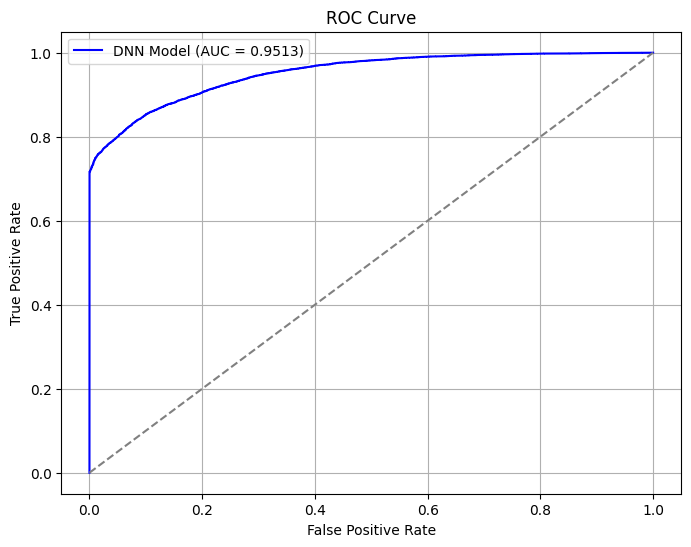

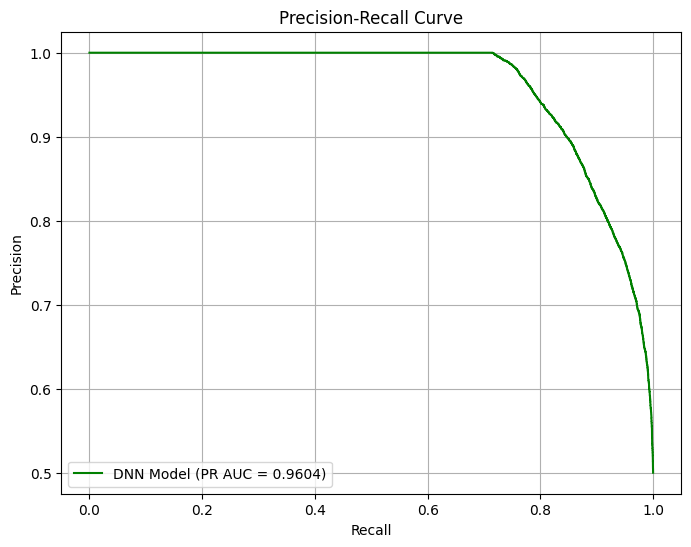

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

# Evaluate DNN model
y_pred_prob_dnn = dnn_model.predict(X_test)
y_pred_dnn = (y_pred_prob_dnn > 0.5).astype(int)

# Compute DNN performance metrics
dnn_accuracy = accuracy_score(y_test, y_pred_dnn)
dnn_f1 = f1_score(y_test, y_pred_dnn)
dnn_mcc = matthews_corrcoef(y_test, y_pred_dnn)
dnn_roc_auc = roc_auc_score(y_test, y_pred_prob_dnn)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_dnn)
dnn_pr_auc = auc(recall, precision)

print(f"DNN Model Performance:")
print(f"Accuracy: {dnn_accuracy:.4f}")
print(f"F1 Score: {dnn_f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {dnn_mcc:.4f}")
print(f"ROC-AUC Score: {dnn_roc_auc:.4f}")
print(f"Precision-Recall AUC: {dnn_pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dnn))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_dnn)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"DNN Model (AUC = {dnn_roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"DNN Model (PR AUC = {dnn_pr_auc:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Confusion Matrix
conf_matrix = pd.crosstab(y_test, y_pred_dnn, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [1]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        inputs = tf.keras.layers.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(128, activation='relu')(inputs)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        outputs = tf.keras.layers.Dense(self.action_size, activation='linear')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def train(self, episodes, batch_size):
        for e in range(episodes):
            state = random.choice(X_train)
            state = np.reshape(state, [1, self.state_size])
            total_reward = 0
            for time in range(50):
                action = self.act(state)
                next_state = random.choice(X_train)
                next_state = np.reshape(next_state, [1, self.state_size])
                reward = 1 if action > 5 else -1
                total_reward += reward
                done = time == 49
                self.remember(state, action, reward, next_state, done)
                state = next_state
                if done:
                    break
            print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward}")
            if len(self.memory) > batch_size:
                self.replay(batch_size)

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.target_model.predict(next_state, verbose=0)))
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

dqn_agent = DQNAgent(state_size=X_train.shape[1], action_size=10)
dqn_agent.train(episodes=500, batch_size=64)


NameError: name 'X_train' is not defined